# Neuron Counter: Image Segmentation and Counting

This notebook implements a deep learning model for segmenting and counting neurons in microscopy images.

## Setup and Imports

In [32]:
import os
import shutil
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from lime import lime_image
from scipy.stats import pearsonr

# Import our modules
from dataset import NeuronDataset
from model import NeuronCounter
from train import train_model, evaluate_model, save_checkpoint

# Set random seeds for reproducibility
random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

## 1. Data Exploration

First, let's look at some example images and their corresponding masks to understand our data.

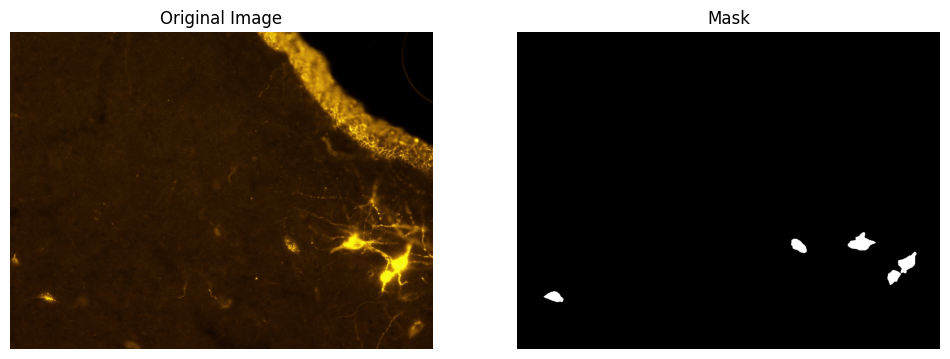

Image size: (1600, 1200)


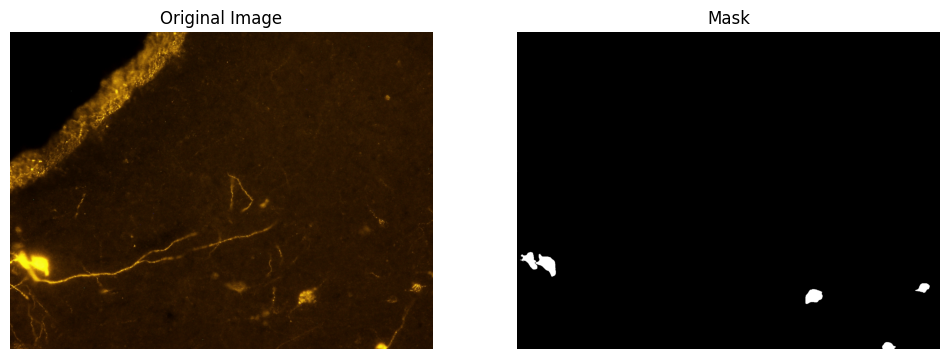

Image size: (1600, 1200)


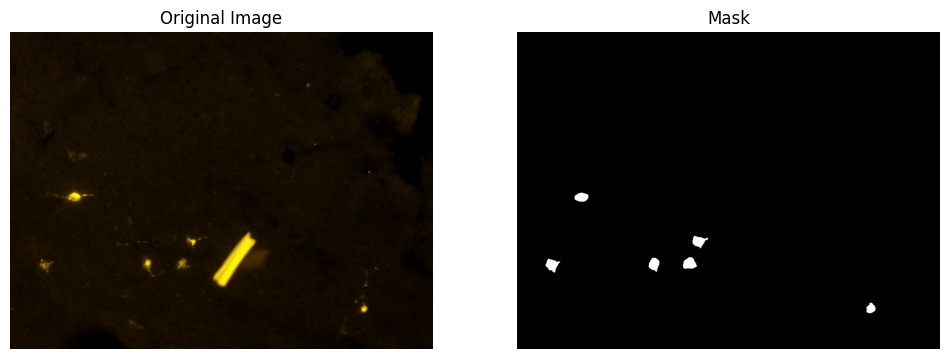

Image size: (1600, 1200)


In [2]:
def show_image_and_mask(image_path, mask_path):
    """Display an image and its corresponding mask side by side"""
    image = Image.open(image_path).convert('RGB')
    mask = Image.open(mask_path).convert('L')
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(image)
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    ax2.imshow(mask, cmap='gray')
    ax2.set_title('Mask')
    ax2.axis('off')
    
    plt.show()

# Show a few example images
image_dir = './dataset/all_images/images/'
mask_dir = './dataset/all_masks/masks/'
image_files = sorted(os.listdir(image_dir))[:3]  # Show first 3 images

for img_file in image_files:
    img_path = os.path.join(image_dir, img_file)
    mask_path = os.path.join(mask_dir, img_file)
    show_image_and_mask(img_path, mask_path)
    # Print image dimensions
    with Image.open(img_path) as img:
        print(f'Image size: {img.size}')

## 2. Data Preprocessing and Split

Now we'll organize our data into training and testing sets. We'll create new directories for each split and copy the files accordingly.

In [3]:
def create_train_test_split(src_img_dir, src_mask_dir, train_ratio=0.8, seed=42):
    """Split the dataset into training and testing sets and organize into directories"""
    # Create directories
    base_dir = './dataset'
    for split in ['train', 'test']:
        for dtype in ['images', 'masks']:
            os.makedirs(os.path.join(base_dir, split, dtype), exist_ok=True)
    
    # Get list of images and shuffle
    all_images = sorted(os.listdir(src_img_dir))
    random.seed(seed)
    random.shuffle(all_images)
    
    # Split into train and test
    split_idx = int(len(all_images) * train_ratio)
    train_images = all_images[:split_idx]
    test_images = all_images[split_idx:]
    
    # Copy files to respective directories
    for img_file in train_images:
        shutil.copy2(os.path.join(src_img_dir, img_file),
                     os.path.join(base_dir, 'train', 'images', img_file))
        shutil.copy2(os.path.join(src_mask_dir, img_file),
                     os.path.join(base_dir, 'train', 'masks', img_file))
    
    for img_file in test_images:
        shutil.copy2(os.path.join(src_img_dir, img_file),
                     os.path.join(base_dir, 'test', 'images', img_file))
        shutil.copy2(os.path.join(src_mask_dir, img_file),
                     os.path.join(base_dir, 'test', 'masks', img_file))
    
    print(f'Total images: {len(all_images)}')
    print(f'Train images: {len(train_images)}')
    print(f'Test images: {len(test_images)}')
    
    return {
        'train': {
            'images': os.path.join(base_dir, 'train', 'images'),
            'masks': os.path.join(base_dir, 'train', 'masks')
        },
        'test': {
            'images': os.path.join(base_dir, 'test', 'images'),
            'masks': os.path.join(base_dir, 'test', 'masks')
        }
    }

# Create train/test split
data_dirs = create_train_test_split(
    src_img_dir='./dataset/all_images/images/',
    src_mask_dir='./dataset/all_masks/masks/',
    train_ratio=0.8
)

Total images: 283
Train images: 226
Test images: 57


## 3. Create Data Loaders

Now we'll set up our data loaders with appropriate transforms. We'll also visualize a batch of data to make sure everything looks correct.

Batch shapes:
Images: torch.Size([8, 3, 128, 128])
Masks: torch.Size([8, 1, 128, 128])
Counts: torch.Size([8])


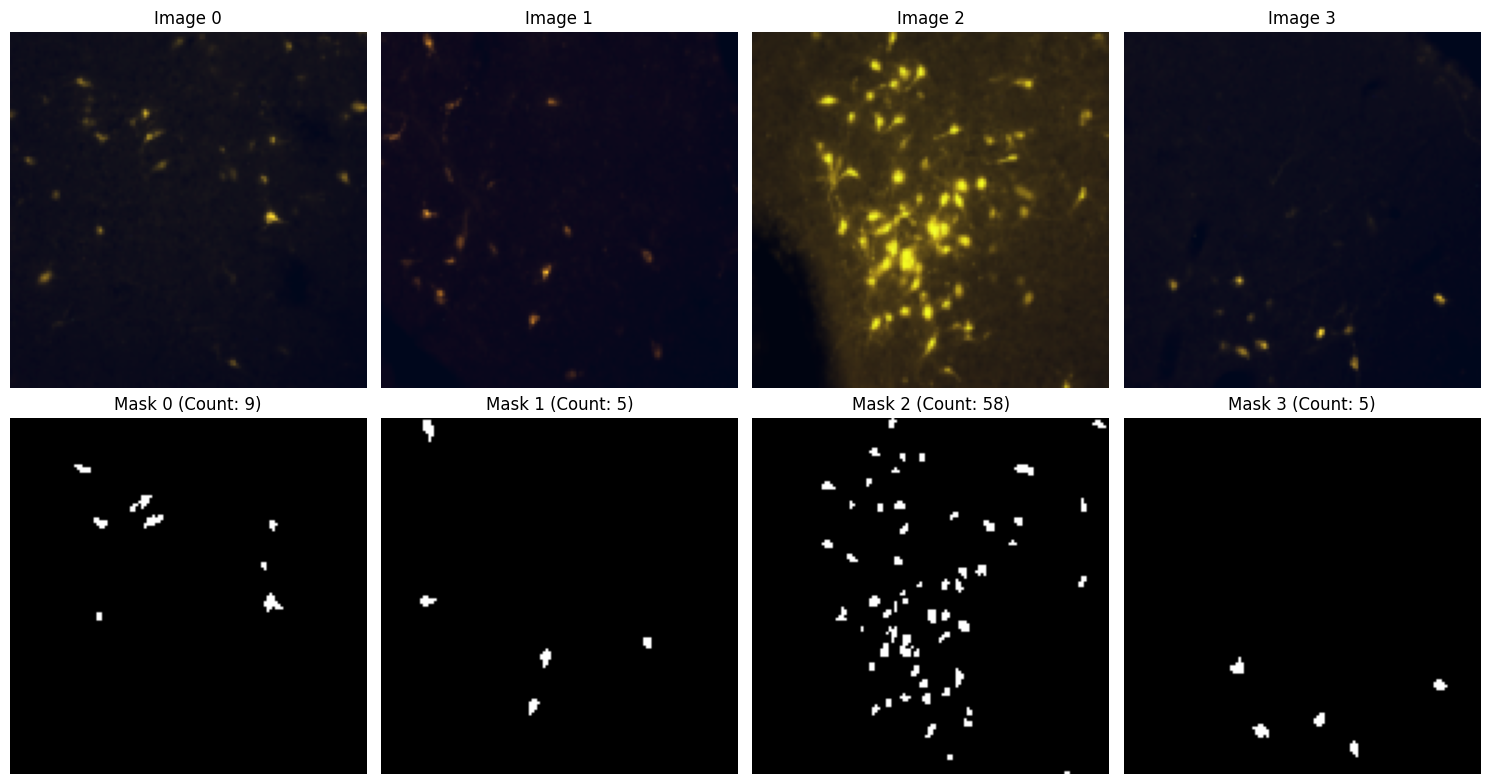

In [4]:
def create_data_loaders(data_dirs, input_size=128, batch_size=8):
    """Create training and testing data loaders"""
    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    train_dataset = NeuronDataset(
        image_dir=data_dirs['train']['images'],
        mask_dir=data_dirs['train']['masks'],
        transform=transform
    )
    
    test_dataset = NeuronDataset(
        image_dir=data_dirs['test']['images'],
        mask_dir=data_dirs['test']['masks'],
        transform=transform
    )
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

# Create the data loaders
train_loader, test_loader = create_data_loaders(data_dirs, batch_size=8)

# Display a batch of training data
images, masks, counts = next(iter(train_loader))
print(f'Batch shapes:')
print(f'Images: {images.shape}')
print(f'Masks: {masks.shape}')
print(f'Counts: {counts.shape}')

# Display first few images in the batch
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
for i in range(4):
    # Show image
    img = images[i].permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())  # Denormalize
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Image {i}')
    
    # Show mask
    axes[1, i].imshow(masks[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Mask {i} (Count: {counts[i]:.0f})')

plt.tight_layout()
plt.show()

## 4. Model Training

Now we'll train our model. We'll track both training and testing metrics and save the best model based on test loss.

In [5]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Initialize model and move to device
model = NeuronCounter(input_size=128).to(device)

# Loss functions and optimizer
criterion_seg = nn.BCELoss()
criterion_count = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training configuration
num_epochs = 50
save_dir = './checkpoints'
os.makedirs(save_dir, exist_ok=True)

# Training history
history = {
    'train_loss': [],
    'test_loss': [],
    'test_seg_loss': [],
    'test_count_loss': []
}

# Training loop
best_loss = float('inf')
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    
    # Train
    train_loss = train_model(model, train_loader, criterion_seg, criterion_count, 
                            optimizer, device, epoch, save_dir)
    
    # Evaluate
    test_loss, test_seg_loss, test_count_loss = evaluate_model(
        model, test_loader, criterion_seg, criterion_count, device
    )
    
    # Update history
    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    history['test_seg_loss'].append(test_seg_loss)
    history['test_count_loss'].append(test_count_loss)
    
    print(f'Epoch {epoch+1} - Train Loss: {train_loss:.4f}, '
          f'Test Loss: {test_loss:.4f} '
          f'(Seg: {test_seg_loss:.4f}, Count: {test_count_loss:.4f})')
    
    # Save best model
    if test_loss < best_loss:
        best_loss = test_loss
        best_model_path = os.path.join(save_dir, 'best_model.pth')
        save_checkpoint(model, optimizer, epoch, best_loss, best_model_path)
        print(f'New best model saved with test loss: {best_loss:.4f}')

Using device: cuda

Epoch 1/50
Batch 0: Loss = 164.5374 (Seg: 0.7535, Count: 163.7839)
Batch 10: Loss = 351.6998 (Seg: 0.4220, Count: 351.2778)
Batch 20: Loss = 195.9573 (Seg: 0.1736, Count: 195.7836)


c:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 - Train Loss: 159.9606, Test Loss: 8597.7369 (Seg: 0.5562, Count: 8597.1807)
Checkpoint saved: ./checkpoints\best_model.pth
New best model saved with test loss: 8597.7369

Epoch 2/50
Batch 0: Loss = 19.0438 (Seg: 0.2604, Count: 18.7834)
Batch 10: Loss = 30.4002 (Seg: 0.2070, Count: 30.1932)
Batch 20: Loss = 118.7923 (Seg: 0.0397, Count: 118.7526)
Epoch 2 - Train Loss: 58.3365, Test Loss: 768.2366 (Seg: 0.0737, Count: 768.1629)
Checkpoint saved: ./checkpoints\best_model.pth
New best model saved with test loss: 768.2366

Epoch 3/50
Batch 0: Loss = 46.0812 (Seg: 0.0939, Count: 45.9873)
Batch 10: Loss = 162.4528 (Seg: 0.0710, Count: 162.3818)
Batch 20: Loss = 11.8313 (Seg: 0.0356, Count: 11.7957)
Epoch 3 - Train Loss: 51.9970, Test Loss: 6115.0623 (Seg: 0.0631, Count: 6114.9991)

Epoch 4/50
Batch 0: Loss = 22.1214 (Seg: 0.0437, Count: 22.0777)
Batch 10: Loss = 270.0027 (Seg: 0.0459, Count: 269.9568)
Batch 20: Loss = 15.8623 (Seg: 0.0330, Count: 15.8293)
Epoch 4 - Train Loss: 65.537

### Visualize Training Progress

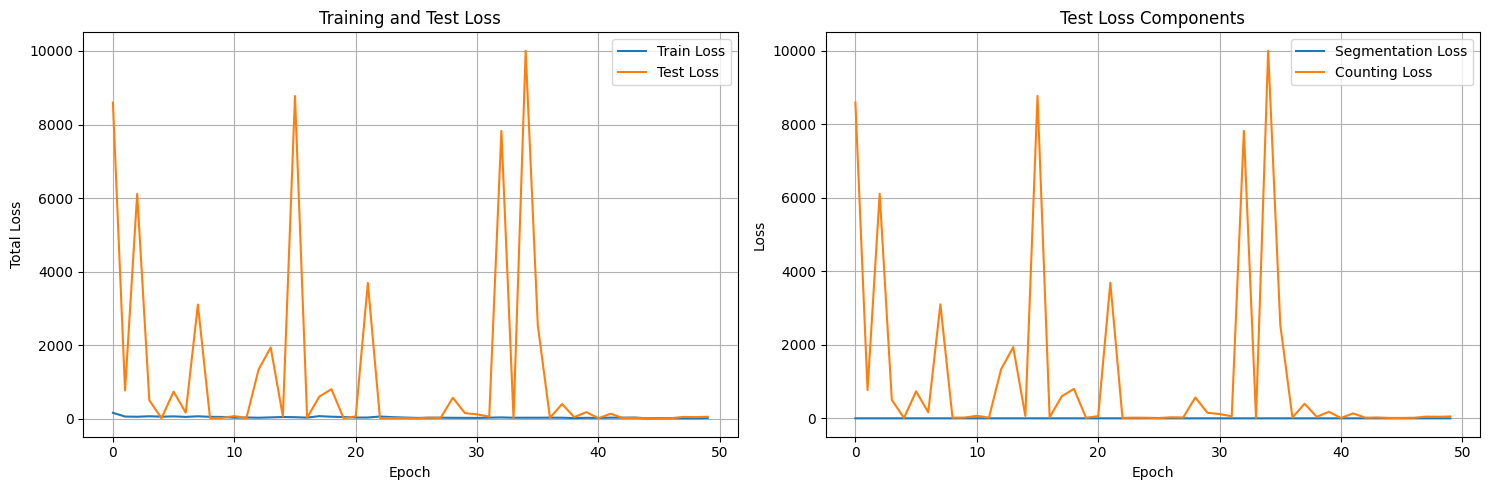

In [6]:
# Plot training history
plt.figure(figsize=(15, 5))

# Plot total loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)

# Plot loss components
plt.subplot(1, 2, 2)
plt.plot(history['test_seg_loss'], label='Segmentation Loss')
plt.plot(history['test_count_loss'], label='Counting Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss Components')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 5. Model Evaluation

Now let's evaluate our trained model on the test set. We'll visualize its predictions and analyze its performance.

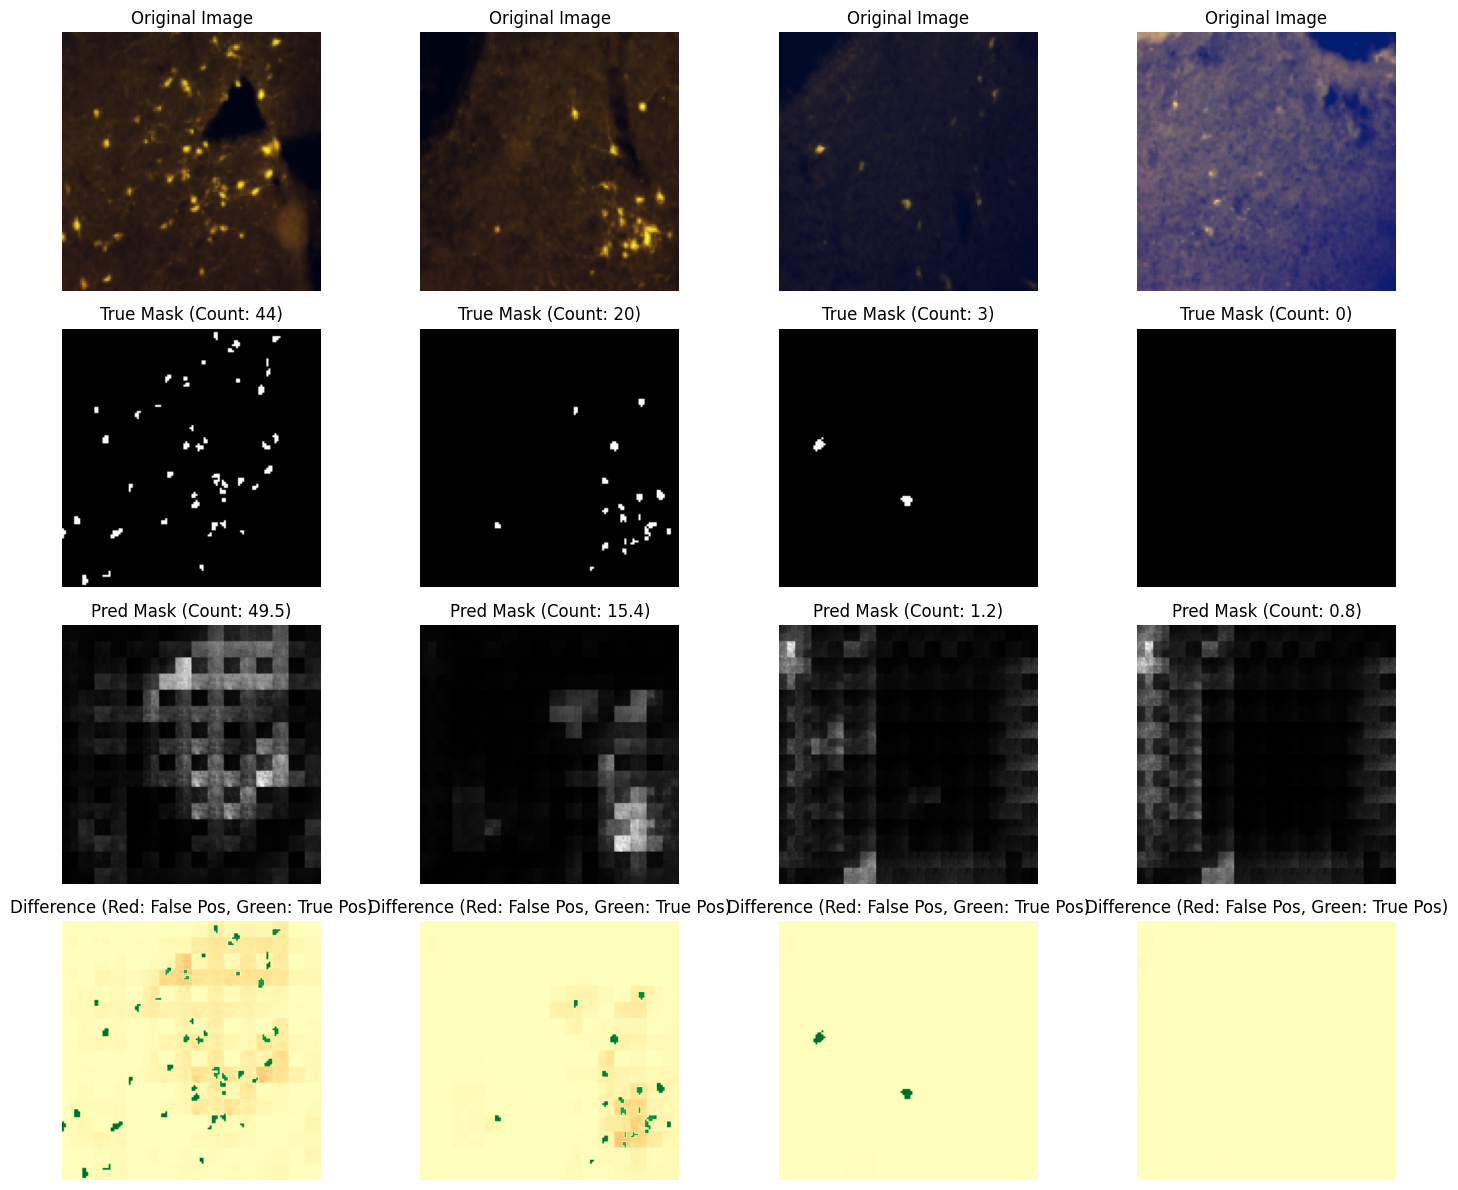

In [25]:
def visualize_predictions(model, test_loader, device, num_samples=4):
    """Visualize model predictions on test data
    
    Args:
        model: Trained model
        test_loader: DataLoader for test data
        device: Device to run model on
        num_samples: Number of samples to visualize
    """
    model.eval()
    
    # Get a batch of test data
    images, masks, counts = next(iter(test_loader))
    images, masks = images.to(device), masks.to(device)
    
    # Get predictions
    with torch.no_grad():
        seg_pred, count_pred = model(images)
    
    # Plot results
    fig, axes = plt.subplots(4, num_samples, figsize=(15, 12))
    
    for i in range(num_samples):
        # Original image
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Denormalize
        axes[0, i].imshow(img)
        axes[0, i].set_title('Original Image')
        axes[0, i].axis('off')
        
        # True mask
        axes[1, i].imshow(masks[i].cpu().squeeze(), cmap='gray')
        axes[1, i].set_title(f'True Mask (Count: {counts[i]:.0f})')
        axes[1, i].axis('off')
        
        # Predicted mask
        axes[2, i].imshow(seg_pred[i].cpu().squeeze(), cmap='gray')
        axes[2, i].set_title(f'Pred Mask (Count: {count_pred[i].item():.1f})')
        axes[2, i].axis('off')
        
        # Difference
        diff = (masks[i].cpu().squeeze() - seg_pred[i].cpu().squeeze()).numpy()
        axes[3, i].imshow(diff, cmap='RdYlGn', vmin=-1, vmax=1)
        axes[3, i].set_title('Difference (Red: False Pos, Green: True Pos)')
        axes[3, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Load best model
best_model_path = os.path.join(save_dir, 'best_model.pth')
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])

# Visualize predictions
visualize_predictions(model, test_loader, device)

## 6. Quantitative Evaluation

Let's compute some quantitative metrics on the test set.

Test Set Metrics:
Mean Error: -0.61 neurons
Mean Absolute Error: 1.94 neurons
Correlation Coefficient: 0.954
Pearson Correlation: 0.954


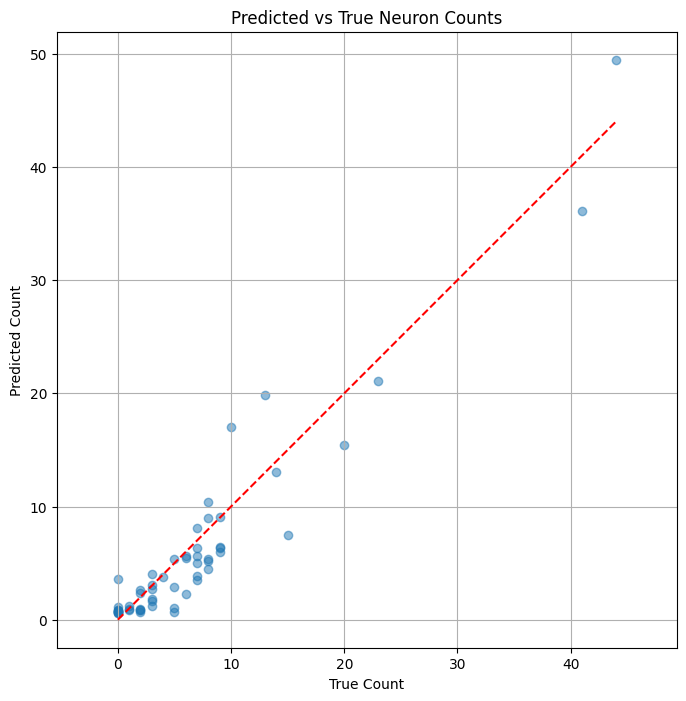

In [33]:
def compute_metrics(model, test_loader, device):
    """Compute various metrics on the test set"""
    model.eval()
    total_count_error = 0
    total_count_abs_error = 0
    total_samples = 0
    count_predictions = []
    count_targets = []
    
    with torch.no_grad():
        for images, masks, counts in test_loader:
            images = images.to(device)
            counts = counts.to(device)
            
            # Get predictions
            _, count_pred = model(images)
            
            # Compute errors
            error = count_pred.squeeze() - counts
            total_count_error += error.sum().item()
            total_count_abs_error += error.abs().sum().item()
            total_samples += counts.size(0)
            
            # Store predictions and targets for correlation
            # Append individual values instead of trying to extend
            for pred in count_pred.squeeze().cpu().numpy().flatten():
                count_predictions.append(float(pred))
            for target in counts.cpu().numpy().flatten():
                count_targets.append(float(target))
    
    # Calculate metrics
    mean_error = total_count_error / total_samples
    mean_abs_error = total_count_abs_error / total_samples
    correlation = np.corrcoef(count_predictions, count_targets)[0, 1]
    
    return {
        'mean_error': mean_error,
        'mean_abs_error': mean_abs_error,
        'correlation': correlation,
        'predictions': count_predictions,
        'targets': count_targets
    }

# Compute and display metrics
metrics = compute_metrics(model, test_loader, device)

mean_error = metrics['mean_error']
mean_abs_error = metrics['mean_abs_error'] 
correlation = metrics['correlation']
pearson_r, p_value = pearsonr(metrics['targets'], metrics['predictions'])

print(f"Test Set Metrics:")
print(f"Mean Error: {mean_error:.2f} neurons")
print(f"Mean Absolute Error: {mean_abs_error:.2f} neurons")
print(f"Correlation Coefficient: {correlation:.3f}")
print(f"Pearson Correlation: {pearson_r:.3f}")

# Plot correlation between predicted and true counts
plt.figure(figsize=(8, 8))
plt.scatter(metrics['targets'], metrics['predictions'], alpha=0.5)
plt.plot([0, max(metrics['targets'])], [0, max(metrics['targets'])], 'r--')
plt.xlabel('True Count')
plt.ylabel('Predicted Count')
plt.title('Predicted vs True Neuron Counts')
plt.grid(True)
plt.axis('equal')
plt.show()

## 7. Save Model for Deployment

Finally, let's save our best model in a format ready for deployment.

In [10]:
# Create deployment directory
deploy_dir = './deployment'
os.makedirs(deploy_dir, exist_ok=True)

# Save model for deployment
deploy_model_path = os.path.join(deploy_dir, 'neuron_counter_model.pth')
deploy_info = {
    'model_state_dict': model.state_dict(),
    'input_size': 128,
    'normalize_mean': [0.485, 0.456, 0.406],
    'normalize_std': [0.229, 0.224, 0.225],
    'test_metrics': metrics
}

torch.save(deploy_info, deploy_model_path)
print(f'Model saved for deployment at: {deploy_model_path}')

Model saved for deployment at: ./deployment\neuron_counter_model.pth
